### Introduction

Constraint-based metabolic models can not only be used to predict the wild type flux phenotype and properties of an organism, it can also be used to predict the behaviour of mutants by simulating gene/reaction deletions Consequently, metabolic modeling can be used to generate candidates and biological hypotheses before initiating expensive and time-consuming experiments in the lab. In this project, you will be using a computational framework, OptKnock, to identify candidate mutants with increased productivities of a target metabolite of interest.

### 1.1 Metabolic engineering with OptKnock
(i) Explain what flux variability analysis is and how it is used to find flux ranges of reactions in constraint-based metabolic models.

**Observation:** 
Flux variability analysis (FVA) is a method for evaluating the minimum and maximum reaction
fluxes in constraint-based metabolic models at a given fraction of the optimal objective value. In
other words, FVA allows us to investigate the variability of reaction fluxes as they often can take on
a range of values. The problem is solved as a double linear programming problem by first maximizing
the flux of a reaction at a given fraction of the optimal objective value, then minimizing it.

(ii) Using the *Escherichia coli* core model, what is the flux variability of acetate and succinate excretion when the model is growing optimally? What about at 50% of its optimal growth rate? Is the secretion of these metabolites coupled with growth? Discuss.

In [3]:
import cobra
import tbtFunctions as tbt
import matplotlib.pyplot as plt
import json
import sys
import warnings
import copy

# Suppress annoying warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

def write_flux_json(filename, model):
    ''' write_flux_json writes a json file from a dictionary of model reactions
    and associated flux values
    '''
    model.optimize()
    flux_dict = cobra.core.solution.get_solution(model).fluxes.to_dict()    # reaction:flux dict
    with open(filename, 'w') as f:
        json.dump(flux_dict, f)

# Read model
ecoli_core =  cobra.io.read_sbml_model('ecoli_core_model.xml')
ecoli_core.solver = 'glpk'

print('\n\nTable 1:')
# Flux variability acetate (100% and 50% of optimal growth)
fva_ac_100 = cobra.flux_analysis.flux_variability_analysis(ecoli_core, 'EX_ac_e', fraction_of_optimum=1)
fva_ac_50 = cobra.flux_analysis.flux_variability_analysis(ecoli_core, 'EX_ac_e', fraction_of_optimum=0.5)
print('Acetate secretion (100% optimal), min flux: {:.4f}, max flux: {:.4f}'.format(fva_ac_100['minimum'][0], fva_ac_100['maximum'][0]))
print('Acetate secretion (50% optimal), min flux: {:.4f}, max flux: {:.4f}'.format(fva_ac_50['minimum'][0], fva_ac_50['maximum'][0]))

# Flux variability succinate (100% and 50% of optimal growth)
fva_succ_100 = cobra.flux_analysis.flux_variability_analysis(ecoli_core, 'EX_succ_e', fraction_of_optimum=1)
fva_succ_50 = cobra.flux_analysis.flux_variability_analysis(ecoli_core, 'EX_succ_e', fraction_of_optimum=0.5)

print('Succinate secretion (100% optimal), min flux: {:.4f}, max flux: {:.4f}'.format(fva_succ_100['minimum'][0], fva_succ_100['maximum'][0]))
print('Succinate secretion (50% optimal), min flux: {:.4f}, max flux: {:.4f}'.format(fva_succ_50['minimum'][0], fva_succ_50['maximum'][0]))





Table 1:
Acetate secretion (100% optimal), min flux: 0.0000, max flux: 0.0000
Acetate secretion (50% optimal), min flux: 0.0000, max flux: 13.3589
Succinate secretion (100% optimal), min flux: 0.0000, max flux: -0.0000
Succinate secretion (50% optimal), min flux: 0.0000, max flux: 8.3075


**Observations:**

Simulating the flux variability of acetate and succinate secretion at $100$% and $50$% of optimal
growth, we find that secretion of these metabolites are not growth coupled in this particular
metabolic model of E. coli. In fact, we find that the model is unable to secrete either when
growing optimally; all available carbon is used for energy and biomass production (see Table 1).

At $50$% of optimal growth, we see that there is capacity for production (i.e. maximal attainable
flux is non-zero), but the minimal flux remains at $0$, suggesting that the model still is capable of not
producing any excess of these metabolites. However, as we will see later on, we are able to induce
a direct growth-coupling for these metabolites through reaction knockouts using the OptKnock
framework.

(iii) In your own words, provide a description of OptKnock. What is it used for and what are the underlying assumptions of the framework?

**Observations:**

OptKnock is a computational framework to identify knockout mutant candidates with increased
production of a target metabolite of interest. The algorithm attempts to identify single- or multiple
reaction knockouts in which the flux through a target reaction is increased compared to that of the
wild type. The algorithm works by altering the topology of the metabolic network through reaction
deletions to induce a (stronger) flux coupling between growth and target metabolite production.
Subsequent optimization for growth will consequently necessitate production of the target metabo-
lite. The underlying assumption of the method is that the organism has evolved towards optimal
growth not only before, but also following the genetic perturbation (i.e. knockout). We will later
discuss how this assumption might be invalid.

(iv) We will now use OptKnock, found as the function `phonyOptKnock` in the `tbtFunctions` module to identify reactions whose associated genes can be knocked out to increase acetate secretion. As the name of the function might suggest, this is not a proper implementation of the OptKnock algorithm as the one that should have been compatible with cobrapy is buggy and rather annoying. This brute-force implementation instead tests all individual knockout combinations (after some reaction filtering) and rank-orders them based on the results. Since we are working with the relatively small *E. coli* core model, simulating single and double knockout combinations are rather quick. However, be wary of the time complexity if you want to test triple and quadruple knockout strategies... 

(a) In the result dataframe returned by `phonyOptKnock`, what do you think is most useful for making predictions of acetate secretion, fva_min or fva_max?

**Observations:**

fva_min and fva_max are the results of running FVA on the target metabolite exchange reaction, 
when a reaction(s) has been deleted from the model. As such, at $100$% optimal conditions,
it gives the interval of target metabolite exchange fluxes. If the cell is growing $100$% optimally,
fva_min gives the minimum expected exchange flux. fva_min is therefore what we should use
when trying to find reactions to knock out to increase the target exchange flux, since if a
reaction has fva_min $= 0$ but maxProd $> 0$, it's entirely possible to have zero target metabo-
lite exchange flux when the cell is growing optimally. When minProd $> 0$, we have a growth
coupled mutant, meaning that optimal growth is flux-coupled to target compound production.


(b) Perform a single knockout deletion with `OptKnock` for acetate secretion. How many candidate mutants have enforced acetate production at optimal growth? What is/are the best-performing mutant(s)?

In [4]:
#Single knockout OptKnock acetate
single_ac = tbt.phonyOptKnock(ecoli_core, 'EX_ac_e', reactions=None, knockouts=1)
single_ac.head()

,reactions,target,biomass,fva_min,fva_max
12,[CYTBD],8.503585,0.211663,8.503585,8.503585
42,[NADH16],8.503585,0.211663,8.503585,8.503585
0,[ACALD],0.0,0.873922,0.0,0
54,[PPS],0.0,0.873922,0.0,0
39,[MDH],0.0,0.825819,0.0,0


**Observations:**

Running `OptKnock` for acetate production with one knockout, we find two candidate mutants
with an enforced production of acetate, evident from the non-zero flux of fva min. These
mutants have knocked out the reactions CYTBD (cytochrome oxidase) and NADH16 (NADH
dehydrogenase), respectively. Thus, if these mutants grow optimally, the model predicts that
they necessarily have to secrete acetate at a minimal flux of around 8.5 mmol gDW<sup>-1</sup> h<sup>-1</sup>.

(c) Redo your analysis in (b), but now with double knockouts.

In [5]:
#Double knockout OptKnock acetate
double_ac = tbt.phonyOptKnock(ecoli_core, 'EX_ac_e', reactions=None, knockouts=2)
double_ac.head()

,reactions,target,biomass,fva_min,fva_max
646,"[ATPS4r, FUM]",14.312267,0.37423,14.312267,14.312267
663,"[ATPS4r, MDH]",14.312267,0.37423,14.312267,14.312267
686,"[ATPS4r, SUCDi]",14.312267,0.37423,14.312267,14.312267
687,"[ATPS4r, SUCOAS]",14.312267,0.37423,13.239874,14.312267
396,"[AKGDH, ATPS4r]",14.312267,0.37423,13.239874,14.312267


**Observations:**

We now find $122$ double knockout mutant candidates with an enforced acetate production
(fva_min $> 0$). These production fluxes range from $0.14$ mmol gDW<sup>-1</sup> h<sup>-1</sup> for the worst-
performing candidates, to $14.3$ mmol gDW<sup>-1</sup> h<sup>-1</sup> for the best-performing ones. There are three
best-performing mutants, all with an enforced acetate secretion flux of $14.31$ mmol gDW<sup>-1</sup> h<sup>-1</sup>
at optimal growth. These mutants all have the ATPS4r (ATP synthase) knocked out, as well
as an enzyme of the TCA cycle (FUM: fumarase, MDH: malate dehydrogenase, or SUCDi: succinate dehydrogenase).

(d) Plot the production envelope of acetate secretion vs. growth of the wild type model and one of the best-performing mutants in (b-c). In your own words, explain what this figure is showing.

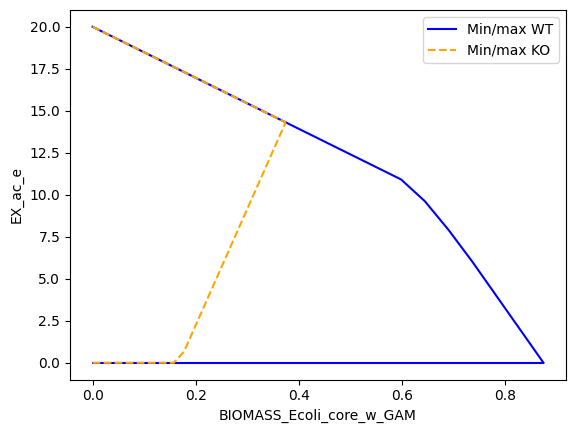

In [6]:
fig1, ax1 = plt.subplots()
prod_env = cobra.flux_analysis.production_envelope(ecoli_core, ['BIOMASS_Ecoli_core_w_GAM'], objective='EX_ac_e')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_minimum'], ylabel='EX_ac_e', ax=ax1, color='blue')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_maximum'], ylabel='EX_ac_e', ax=ax1, color='blue')

# Knockout reactions by constraining flux to 0
ac_model = copy.deepcopy(ecoli_core)
ac_model.reactions.FUM.lower_bound = 0.0
ac_model.reactions.FUM.upper_bound = 0.0
ac_model.reactions.ATPS4r.lower_bound = 0.0
ac_model.reactions.ATPS4r.upper_bound = 0.0
prod_env = cobra.flux_analysis.production_envelope(ac_model, ['BIOMASS_Ecoli_core_w_GAM'], objective='EX_ac_e')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_minimum'], ylabel='EX_ac_e', ax=ax1, color='orange', linestyle='dashed')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_maximum'], ylabel='EX_ac_e', ax=ax1, color='orange', linestyle='dashed')
plt.legend(['Min/max WT', '_nolegend_', 'Min/max KO', '_nolegend_'])

**Observations:**

This figure shows us the production envelope for acetate for the wild type and mutant model, and
it is basically a graphical representation of the flux variability in the acetate excretion at different
growth rates (i.e. the minimal and maximal flux of acetate secretion). We see that in our
mutant, acetate production is growth coupled when the specific growth rate exceeds around
$0.15$ h<sup>-1</sup>, while it always is uncoupled with growth in the wild type. In the mutant, the
minimal flux of acetate secretion rapidly increases with growth until it reaches its new growth
optimum of $0.37$ h<sup>-1</sup> with a corresponding min/max acetate secretion of $14.3$ mmol gDW<sup>-1</sup> h<sup>-1</sup>.

(v) Redo (iv) (b-d), but now with succinate secretion as the target reaction.


Single knockout:
   reactions target   biomass fva_min fva_max
0    [ACALD]    0.0  0.873922     0.0       0
37    [MALS]    0.0  0.873922     0.0       0
39     [MDH]    0.0  0.825819     0.0       0
40     [ME1]    0.0  0.873922     0.0       0
41     [ME2]    0.0  0.873922     0.0       0

Double knockout:
            reactions    target   biomass   fva_min   fva_max
756    [CYTBD, FORti]  0.678148  0.179985  0.678148  0.678148
783      [CYTBD, PFL]  0.678148  0.179985  0.678148  0.678148
0       [ACALD, ACKr]       0.0  0.873922       0.0         0
1612  [GLUN, MALt2_2]       0.0  0.873922       0.0         0
1620      [GLUN, PFL]       0.0  0.873922       0.0         0


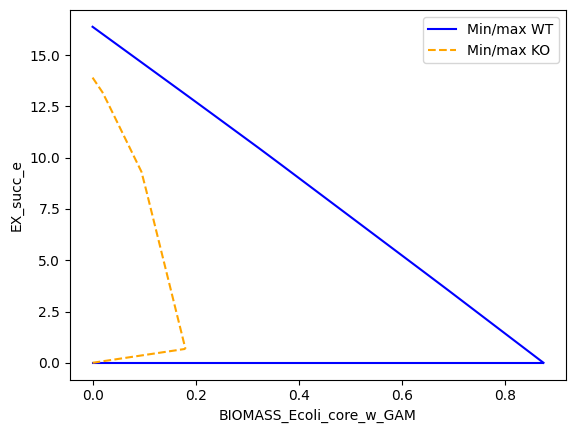

In [7]:
# (v) b) Single knockout OptKnock succinate
single_succ = tbt.phonyOptKnock(ecoli_core, 'EX_succ_e', reactions=None, knockouts=1)
print("\nSingle knockout:")
print(single_succ.head())

# c) Double knockout OptKnock succiante
double_succ = tbt.phonyOptKnock(ecoli_core, 'EX_succ_e', reactions=None, knockouts=2)
print("\nDouble knockout:")
print(double_succ.head())

# d) Production envelope succinate (wild type and mutant)
fig2, ax2 = plt.subplots()
prod_env = cobra.flux_analysis.production_envelope(ecoli_core, ['BIOMASS_Ecoli_core_w_GAM'], objective='EX_succ_e')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_minimum'], ylabel='EX_succ_e', ax=ax2, color='blue')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_maximum'], ylabel='EX_succ_e', ax=ax2, color='blue')

# Knockout reactions by constraining flux to 0 (double KO CYTBD + PFL)
succ_model = copy.deepcopy(ecoli_core)
succ_model.reactions.CYTBD.lower_bound = 0.0
succ_model.reactions.CYTBD.upper_bound = 0.0
succ_model.reactions.PFL.lower_bound = 0.0
succ_model.reactions.PFL.upper_bound = 0.0
prod_env = cobra.flux_analysis.production_envelope(succ_model, ['BIOMASS_Ecoli_core_w_GAM'], objective='EX_succ_e')

prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_minimum'], ylabel='EX_succ_e', ax=ax2, color='orange', linestyle='dashed')
prod_env.plot(kind='line', x='BIOMASS_Ecoli_core_w_GAM', y=['flux_maximum'], ylabel='EX_succ_e', ax=ax2, color='orange', linestyle='dashed')
plt.legend(['Min/max WT', '_nolegend_', 'Min/max KO', '_nolegend_'])

(b)

**Observations:**
No single knockout candidate mutants have an enforced succinate production at optimal
growth. This suggests that, using this particular model, we are not able to induce a flux
coupling between growth and succinate production using only a single reaction deletion.

(c)

**Observations:**

We find two equally-performing mutant candidates with an enforced succinate production at
optimal growth. Both mutants have knocked out CYTBD (cytochrome oxidase), and either of
PFL (pyruvate formate lyase) or FORti (formate transport). The secretion flux of the mutants
are forced to be around $0.69$ mmol gDW<sup>-1</sup> h<sup>-1</sup> at the growth optimum of $0.18$ h<sup>-1</sup>.

(d)

**Observations:**

The production envelope figure shows how the succinate production, although low, is strictly
growth-coupled at any feasible growth rate from $0$ to its maximum of around $0.18$ h<sup>-1</sup>. 
Consequently, we observe a rather substantial reduction in growth, with a rather minor secretion flux
of succinate. An avenue worth exploring might have been to test triple knockout strategies,
or possible run `OptKnock` on alternative environmental conditions such as anaerobic growth.

(vi) Pick one of the best performing double knockout mutants in (iv) or (v) and visualize its optimal flux distribution and compare it to that of the wild type. Provide a biochemical explanation for why the mutant has a higher secretion of acetate/succinate.

In [8]:
# (vi) Visualize flux distributions
succ_CYTBD_model = copy.deepcopy(ecoli_core)
succ_CYTBD_model.reactions.CYTBD.lower_bound = 0.0
succ_CYTBD_model.reactions.CYTBD.upper_bound = 0.0
write_flux_json('wild_type.json', ecoli_core)  # wild type
write_flux_json('CYTDB_KO.json', succ_CYTBD_model)  # CYTBD KO
write_flux_json('double_succ_KO.json', succ_model)  # succinate double KO

**Observations:**
We see that introducing the knockout of CYTBD (cytochrome oxidase) induces a production of
the fermentation products acetate, ethanol and formate. By further knocking out PFL (pyruvate
formate lyase), or alternatively, FORti (formate transport) we effectively force flux back into the
TCA cycle, but now in the opposite direction of the wild type model, eventually producing succinate.

Alternatively to using the online version of Escher, we can display the flux distributions inline in this Jupyter notebook:

In [10]:
import escher
builder1 = escher.Builder(
    height=500,
    map_name='',
    model_json='e_coli_core.json',
    map_json='e_coli_core.Core metabolism.json',
)
print("\n\nFlux distribution of the wild type E. coli core model")
solution = ecoli_core.optimize()
builder1.reaction_data = solution.fluxes
builder1



Flux distribution of the wild type E. coli core model


Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 0.0, 'ACONTa': 6.007249575350337, 'ACONTb': 6.0072…

In [11]:
builder2 = escher.Builder(
    height=500,
    map_name='',
    model_json='e_coli_core.json',
    map_json='e_coli_core.Core metabolism.json',
)
print("\n\nFlux distribution of the delta-CYTBD mutant E. coli core model")
solution = succ_CYTBD_model.optimize()
builder2.reaction_data = solution.fluxes
builder2



Flux distribution of the delta-CYTBD mutant E. coli core model


Builder(reaction_data={'ACALD': -8.279455380486583, 'ACALDt': 0.0, 'ACKr': -8.503585277961305, 'ACONTa': 0.228…

In [12]:
builder3 = escher.Builder(
    height=500,
    map_name='',
    model_json='e_coli_core.json',
    map_json='e_coli_core.Core metabolism.json',
)
print("\n\nFlux distribution of the delta-CYTBD delta-PFL mutant E. coli core model")
solution = succ_model.optimize()
builder3.reaction_data = solution.fluxes
builder3



Flux distribution of the delta-CYTBD delta-PFL mutant E. coli core model


Builder(reaction_data={'ACALD': -16.586347970534895, 'ACALDt': 0.0, 'ACKr': 0.0, 'ACONTa': 0.19418596007602476…

(vii) In your own words, explain minimization of metabolic adjustment (MOMA) and its underlying assumptions. Using your selected mutant in (iv) or (v) c), simulate the MOMA flux distribution and discuss the resulting growth rate and secretion flux of the target metabolite. If the production of the target metabolite is lower than for the FBA solution, what could you do experimentally to improve the secretion flux?

In [13]:
# (vii) MOMA flux distribution
sol = cobra.flux_analysis.moma(ac_model, solution=ecoli_core.optimize())
print('MOMA growth: {:.4f} h^-1'.format(sol.fluxes['BIOMASS_Ecoli_core_w_GAM']))
print('MOMA acetate secretion: {:.4f} mmol/gDW h'.format(sol.fluxes['EX_ac_e']))

MOMA growth: 0.0560 h^-1
MOMA acetate secretion: -0.0000 mmol/gDW h


**Observations:**

MOMA (minimization of metabolic adjustment) is used to predict the fluxes of organisms 
immediately following a perturbation such as a gene knockout by finding a flux vector in this new
solution space that is as close as possible to the original flux vector of the wild type model. This
is usually found by minimizing the Euclidean distance and is commonly formulated as a quadratic
programming problem. It relies on the assumption that the organism have yet to have had time to
re-organize its fluxes by altering its metabolic regulation towards growth optimality. The resulting
flux distribution will instead be as close as possible to that of the wild type flux distribution. 
This is motivated by the fact that the growth phenotype of mutants immediately following a knockout
is usually far from a theoretical optimum predicted by standard FBA, which requires adaptive
laboratory evolution over many generations to achieve.

By simulating the MOMA flux distribution of our best-performing double-knockout mutant from
(iv) c), we see that MOMA predicts that the growth rate and acetate secretion flux only will be
$0.056$ h<sup>-1</sup> and $0.0$ mmol gDW<sup>-1</sup> h<sup>-1</sup>, respectively. Thus we would 
expect that immediately followingthe genetic perturbation (knockout), the mutant will grow poorly and 
not secrete any acetate. In first of the production envelope plots in the project, the mutant is situated 
at a growth rate below $0.15$ h<sup>-1</sup>, thus there is no enforced flux coupling of acetate 
secretion and biomass production. By selecting for fast growers over time (adaptive laboratory evolution), 
we could move the flux distribution from its sub-optimal MOMA distribution towards growth optimality of 
the FBA solution, which should entail a substantial increase in acetate secretion (see first prod. env. plot).

(viii) Thraustochytrids are heterotrophic microorganisms that under nitrogen depletion and growth cessation begins synthesizing and accumulating large amounts of lipids containing $\omega$-3-fatty acids. Given what you have learned about OptKnock, discuss whether or not this method might be applicable for this specific problem to identify potential knockout mutants with increased lipid productivities.

**Observations:**

Here, there is no clear right or wrong answer. The major observation that could indicate that
OptKnock might not be the best approach, is that lipid production is innately uncoupled to biomass
production as the organism begins synthesizing it in response to nitrogen being depleted from the
medium (nitrogen is indispensable for synthesis of e.g., proteins, RNA, and DNA). Evolutionary
this is a commonly observed strategy of scavenging and storing carbon for energy in preparation
for an ensuing period of starvation (no available nitrogen for biomass production). Consequently,
inducing a growth coupling might overall be sub-optimal as this would reduce the growth yield,
resulting in low cell masses to produce more lipids once the nitrogen eventually is depleted from
the media. However, experimental efforts have been performed on certain thraustochytrid strains
in chemostat cultures where lipids are produced continuously. Inducing a stronger growth coupling
for lipid production could therefore be an approach worth exploring further.